# Using of heuristics on very small graph

## Return Zachary’s Karate Club graph.
Each node in the returned graph has a node attribute 'club' that indicates the name of the club to which the member represented by that node belongs, either 'Mr. Hi' or 'Officer'.

from https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.social.karate_club_graph.html

In [1]:
# Setting up enivironment
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt

In [3]:
from myNode2vec import Node2Vec

C:\Users\Adeliia\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


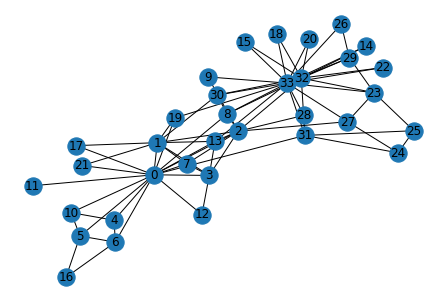

In [4]:
n=34
m = 78
G_karate = nx.karate_club_graph()

pos = nx.spring_layout(G_karate)
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)

In [ ]:
G_karate.size()

In [5]:
G_karate.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [ ]:
G_karate.edges()

In [6]:
G_karate.node[5]['club']

'Mr. Hi'

In [ ]:
G_karate.node[9]['club']

In [ ]:
node2vec = Node2Vec(G_karate, walk_length=30, num_walks=200, workers=1, p=1, q=1)

In [ ]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
# model.wv.get_vector('2')

In [ ]:
model.wv.most_similar('2')

In [ ]:
node2vec2 = Node2Vec(G_karate, walk_length=30, num_walks=200, workers=1, p=1, q=1)

In [ ]:
model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)

In [ ]:
model2.wv.most_similar('2')

In [7]:
lables = 0 if G_karate.node[int(node)]['club'] == 'Mr. Hi' else 1

NameError: name 'node' is not defined

## Edge Embedding
Edges can also be embedded, and the embedding can be further used for classification.
from https://maelfabien.github.io/machinelearning/graph_5/#node-embedding

In [ ]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [ ]:
edges_embs[('1', '2')]

Again, we can retrieve the most similar edge, which can be used for missing edges prediction for example :

In [ ]:
edges_kv = edges_embs.as_keyed_vectors()
edges_kv.most_similar(str(('1', '2')))

## K-means clustering

In [11]:
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import f1_score

In [14]:
# there are 2 groups of karatists 'Mr. Hi' and 'Officer'
lables = []
for i in list(G_karate.nodes):
    lables.append(0 if G_karate.node[i]['club']== 'Mr. Hi' else 1) 

print(lables)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Learning of the parametres influence

In [5]:
def calc_scores (G, num_clusters, walk_length=80, num_walks=10, p=1, q=1):
    print ('walk_length:', walk_length, ', num_walks:', num_walks, ', p:', p, ', q:', q)
    
    #node2vec
    node2vec = Node2Vec(G, dimensions=128, walk_length = walk_length, num_walks=num_walks, p=p, q=q)
    model = node2vec.fit(window=10, min_count=1)
    
    #clustering
    print('clustering started')
    X = model[model.wv.vocab]    
    kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=25)
    kmeans.fit(X)
    assigned_clusters = kmeans.labels_
    
    #labels sorting: so assigned_clusters and sorted_lables are in the same order of nodes 
    sorted_lables = []
    nodes_order = []
    nodes = list(model.wv.vocab)
    for i, node in enumerate(nodes):
        nodes_order.append(int(node))
        sorted_lables.append(0 if G_karate.node[int(node)]['club'] == 'Mr. Hi' else 1)

    #scores
    adj_rand_score = adjusted_rand_score(assigned_clusters, sorted_lables)
    f1_micro = f1_score(sorted_lables, assigned_clusters, average='micro')  
    
    return adj_rand_score, f1_micro

In [6]:
def calc_scores_unsorted (G, num_clusters, walk_length=80, num_walks=10, p=1, q=1):
    print ('walk_length:', walk_length, ', num_walks:', num_walks, ', p:', p, ', q:', q)
    
    #node2vec
    node2vec = Node2Vec(G, dimensions=128, walk_length = walk_length, num_walks=num_walks, p=p, q=q)
    model = node2vec.fit(window=10, min_count=1)
    
    #clustering
    print('clustering started')
    X = model[model.wv.vocab]    
    kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=25)
    kmeans.fit(X)
    assigned_clusters = kmeans.labels_

    #scores
    adj_rand_score = adjusted_rand_score(assigned_clusters, lables)
    f1_micro = f1_score(lables, assigned_clusters, average='micro')  
    
    return adj_rand_score, f1_micro

### 6.1 num_walks testing

In [15]:
#sorted
walk_lengths_arr = []
num_walks_arr = []
adj_scores = []
f1_scores = []
clusters_2 = 2

for i in range(80, 90, 10): #walk_length = 80
    for j in range(5, 40, 1): # num_walks = from 10 to 15
        adj_score, f1_micro = calc_scores(G_karate, clusters_2, i, j)
        adj_scores.append(adj_score)
        f1_scores.append(f1_micro)
        walk_lengths_arr.append(i)
        num_walks_arr.append(j)

walks_test = pd.DataFrame(list(zip(walk_lengths_arr, num_walks_arr, adj_scores, f1_scores)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 5 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 6 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 7 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 8 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 8/8 [00:01<00:00,  6.59it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 9 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 10 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 11 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 11/11 [00:01<00:00,  6.98it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 12 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 12/12 [00:01<00:00,  7.25it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 13 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 14 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 14/14 [00:01<00:00,  7.13it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 15 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 15/15 [00:02<00:00,  7.18it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 16 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 17 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 18 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 18/18 [00:02<00:00,  6.58it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 19 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 19/19 [00:02<00:00,  6.70it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 20 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 20/20 [00:03<00:00,  6.21it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 21 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 22 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 22/22 [00:03<00:00,  6.26it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 23 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 23/23 [00:03<00:00,  6.88it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 24 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 24/24 [00:03<00:00,  6.91it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 25 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 26 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 26/26 [00:04<00:00,  6.18it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 27 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 27/27 [00:05<00:00,  4.93it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 28 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 28/28 [00:03<00:00,  7.22it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 29 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 30 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 30/30 [00:04<00:00,  7.19it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 31 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 31/31 [00:04<00:00,  7.20it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 32 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 33 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 34 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 35 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 35/35 [00:05<00:00,  6.83it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 36 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 36/36 [00:05<00:00,  6.85it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 37 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 37/37 [00:05<00:00,  6.85it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 38 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 38/38 [00:05<00:00,  6.85it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 39 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 39/39 [00:05<00:00,  6.51it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [16]:
walk_lengths_arr_ = []
num_walks_arr_ = []
adj_scores_ = []
f1_scores_ = []
clusters_2_ = 2

for i in range(80, 90, 10): #walk_length = 80
    for j in range(5, 40, 1): # num_walks = from 10 to 15
        adj_score, f1_micro = calc_scores_unsorted(G_karate, clusters_2, i, j)
        adj_scores_.append(adj_score)
        f1_scores_.append(f1_micro)
        walk_lengths_arr_.append(i)
        num_walks_arr_.append(j)

walks_test_unsorted = pd.DataFrame(list(zip(walk_lengths_arr_, num_walks_arr_, adj_scores_, f1_scores_)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 5 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 6 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 6/6 [00:00<00:00,  7.01it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 7 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 8 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 8/8 [00:01<00:00,  6.64it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 9 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 10 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 11 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 11/11 [00:01<00:00,  5.74it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 12 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 13 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 14 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 14/14 [00:02<00:00,  6.57it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 15 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 16 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 16/16 [00:02<00:00,  5.69it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 17 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 17/17 [00:02<00:00,  6.94it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 18 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 18/18 [00:03<00:00,  5.84it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 19 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 20 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 21 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 21/21 [00:03<00:00,  5.65it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 22 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 23 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 24 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 24/24 [00:03<00:00,  6.02it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 25 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 26 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 26/26 [00:03<00:00,  6.82it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 27 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 27/27 [00:03<00:00,  7.06it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 28 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 28/28 [00:04<00:00,  6.79it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 29 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 29/29 [00:06<00:00,  4.50it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 30 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 30/30 [00:05<00:00,  5.94it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 31 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 32 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 33 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 33/33 [00:04<00:00,  6.62it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 34 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 34/34 [00:07<00:00,  4.37it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 35 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 35/35 [00:04<00:00,  7.26it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 36 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 36/36 [00:05<00:00,  7.15it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 37 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 37/37 [00:05<00:00,  7.15it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 38 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 38/38 [00:05<00:00,  7.20it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


walk_length: 80 , num_walks: 39 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 39/39 [00:05<00:00,  7.12it/s]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


### 6.2 walk_length testing

In [ ]:
walk_lengths_arr2 = []
num_walks_arr2 = []
adj_scores2 = []
f1_scores2 = []

for i in range(40, 120, 5): #walk_length = 80
    for j in range(10, 11, 1): # num_walks = 10
        adj_score2, f1_micro2 = calc_scores(G_karate, clusters_2, i, j)
        adj_scores2.append(adj_score2)
        f1_scores2.append(f1_micro2)
        walk_lengths_arr2.append(i)
        num_walks_arr2.append(j)

length_test = pd.DataFrame(list(zip(walk_lengths_arr2, num_walks_arr2, adj_scores2, f1_scores2)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

### 6.3 p's testing

In [ ]:
Ps = []
adj_scores3 = []
f1_scores3 = []

for i in np.arange(0.1, 2, 0.1): #p
    adj_score3, f1_micro3 = calc_scores(G_karate,clusters_2, 80, 10, i)
    adj_scores3.append(adj_score3)
    f1_scores3.append(f1_micro3)
    Ps.append(i)

p_test = pd.DataFrame(list(zip(Ps, adj_scores3, f1_scores3)), 
               columns =['p','adj_score', 'f1_score']) 

### 6.4 q's testing

In [ ]:
Qs = []
adj_scores4 = []
f1_scores4 = []

for i in np.arange(0.1, 2, 0.1): #p
    adj_score4, f1_micro4 = calc_scores(G_karate, clusters_2, 80, 10, 1, i)
    adj_scores4.append(adj_score4)
    f1_scores4.append(f1_micro4)
    Qs.append(i)

q_test = pd.DataFrame(list(zip(Qs, adj_scores4, f1_scores4)), 
               columns =['q','adj_score', 'f1_score']) 

In [ ]:
walks_test.max()

In [ ]:
length_test.max()

In [ ]:
p_test.max()

In [ ]:
q_test.max()

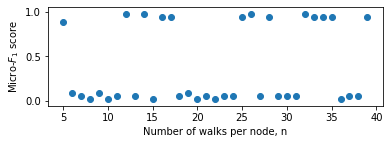

In [17]:
# sorted
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(walks_test['num_walks'], walks_test['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Micro-$F_1$ score')
plt.show()

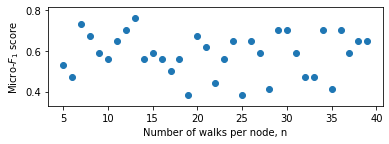

In [18]:
#unsorted 
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(walks_test_unsorted['num_walks'], walks_test_unsorted['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Micro-$F_1$ score')
plt.show()

In [ ]:
fig = plt.figure()
fig.add_subplot(212)
plt.scatter(length_test['walk_length'], length_test['f1_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Micro-$F_1$ score')
plt.show()

In [ ]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(p_test['p'], p_test['f1_score'])
plt.xlabel('p')
plt.ylabel('Micro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(q_test['q'], q_test['f1_score'])
plt.xlabel('q')
plt.ylabel('Micro-$F_1$ score')
plt.show()